# PDE models
The following notebook contains the code that was used to produce all plots in the report for the PDE chapter.

Note that all previous cells must be executed for the code to work.

For reference: the full notebook took about 3 minutes to run on my local machine.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.linalg import toeplitz
from scipy.integrate import solve_ivp
from scipy.stats import vonmises
from IPython.display import HTML
from IPython.display import clear_output

In [2]:
def generate_xs(N):
    xs = np.zeros(N)
    h = 1/N
    for i in range(N):
        xs[i] = i*h
    return xs

def generate_vonMises(N, kappa=0.5):
    xs = np.zeros(N)
    h = 2* np.pi/N
    for i in range(N):
        xs[i] = -np.pi + (i+1)*h
    return vonmises.pdf(xs, kappa, scale=2*np.pi, loc=0.5)

def integration_limits(xs, e_l, e_r):
    limits = np.zeros([len(xs), 2])
    for i in range(len(xs)):
        x = xs[i]
        if x-e_l < 0:
            lower_limit = 1 + x - e_l
        else:
            lower_limit = x - e_l
        if x + e_r > 1:
            upper_limit = (x + e_r) -1
        else:
            upper_limit = x + e_r
        limits[i,0] = lower_limit
        limits[i,1] = upper_limit
    return limits

def make_diff_matrix(N):
    h = 1/N
    c = np.zeros(N)
    for i in range(1, N):
        arg = np.pi*i*h
        c[i] = ((-1)**i)*np.pi*(np.cos(arg)/np.sin(arg))
    
    r = np.zeros(N)
    for i in range(1, N):
        r[i] = c[N-i]
    return toeplitz(c, r)

def interpolation_matrix(x, interp):
    LL = 2*np.pi
    phi = LL * interp
    N = len(x)
    M = np.floor((N+1)/2)
    n1 = np.arange(1, M, dtype=int)
    n2 = np.arange(M+1, N, dtype = int)
    
    interpol = np.zeros([len(interp), N], dtype=complex)
    interpol[:,0] = np.exp(2*np.pi*1j*phi/LL*0)
    for i in range(len(n1)):
        interpol[:,i+1] = np.exp(2 * np.pi * 1j * phi /LL * n1[i])
    interpol[:,len(n1)+1] = np.cos(2*np.pi*M*phi/LL)
    for i in range(len(n2)):
        interpol[:, len(n1)+2+i] = np.exp(2*np.pi*1j* phi /LL * (n2[i] - N))
    interpol = interpol/N
    n = np.arange(0,N, dtype=complex)
    k = n
    help_matrix = np.outer(n,k)/N
    FFT_matrix = np.exp(- 1j * 2 * np.pi * help_matrix)
    return np.real(interpol @ FFT_matrix)

def chebychev(start, end, N):
    theta = np.zeros(N+1)
    length = (end - start)/2
    for i in range(N+1):
        theta[i] = i * np.pi/N
    x = np.cos(theta)
    x = np.add(length * x, end-length)
    w = np.zeros(N+1)
    w[0] = length*1/(N**2 - 1)
    w[N] = w[0]
    
    v = np.ones(N-1)
    for k in range(1, int(N/2)):
        v = v - 2* np.cos(2*k*theta[1:N]) / (4* k**2 - 1)
    v = v - np.cos(N*theta[1:N])/(N**2 - 1)
    w[1:N] = length*2*v/N
    return x, w

def dynamics(xs, r_0, e_l, e_r, sigma, t_end, timepoints = 100, t_eval="standard"):
    N = len(xs)
    D = make_diff_matrix(N)
    D_sq = D @ D
    
    # find optimal number of chebyshev points
    points_in_integration_interval = (e_l + e_r) * N
    number_cheb_points = int(points_in_integration_interval/2) * 2
    
    # calculate chebychev points and weights of each interval [x[i]-e_l, x[i]+e_r]
    int_lim = integration_limits(xs, e_l, e_r)
    data = []
    for j in range(N):
        x = xs[j]
        lower_lim = int_lim[j,0]
        upper_lim = int_lim[j,1]
        if lower_lim > upper_lim:
            points_1, weights1 = chebychev(lower_lim, 1, number_cheb_points)
            points_2, weights2 = chebychev(0, upper_lim, number_cheb_points)
            data.append({
                'limitL': lower_lim,
                'limitR': upper_lim,
                'pointsL': points_1, 
                'weightsL': weights1, 
                'intMatL': interpolation_matrix(xs, points_1),
                'pointsR': points_2,
                'weightsR': weights2,
                'intMatR': interpolation_matrix(xs, points_2)
            })
        else:
            points, weights = chebychev(lower_lim, upper_lim, number_cheb_points)
            data.append({
                'limitL': lower_lim,
                'limitR': upper_lim,
                'points': points,
                'weights': weights,
                'intMat': interpolation_matrix(xs, points)
            })
        
    
    def d_dt(t, r):
        integral = np.ones(N)
        for i in range(N):
            x = xs[i]
            integral_data = data[i]
            lower_lim = int_lim[i,0]
            upper_lim = int_lim[i,1]
            if lower_lim <=x and x <= upper_lim:
                x_cheb = integral_data['points']
                interpolationMatrix = integral_data['intMat']
                chebWeights = integral_data['weights']
                integrand = np.add(x, -x_cheb) * (interpolationMatrix @ r)
                integral[i] = np.sum(chebWeights * integrand)
            elif x > upper_lim:
                chebPoints_L = integral_data['pointsL']
                chebWeights_L = integral_data['weightsL']
                interpolationMatrix_L = integral_data['intMatL']
                integrand_L = np.add(x, -chebPoints_L) * (interpolationMatrix_L @ r)
                
                chebPoints_R = integral_data['pointsR']
                chebWeights_R = integral_data['weightsR']
                interpolationMatrix_R = integral_data['intMatR']
                integrand_R = np.add(x-1, -chebPoints_R) * (interpolationMatrix_R @ r)
                
                integral[i] = np.sum(chebWeights_L * integrand_L) + np.sum(chebWeights_R * integrand_R)
            elif x < lower_lim:
                chebPoints_L = integral_data['pointsL']
                chebWeights_L = integral_data['weightsL']
                interpolationMatrix_L = integral_data['intMatL']
                integrand_L = np.add(x+1, -chebPoints_L) * (interpolationMatrix_L @ r)
                
                chebPoints_R = integral_data['pointsR']
                chebWeights_R = integral_data['weightsR']
                interpolationMatrix_R = integral_data['intMatR']
                integrand_R = np.add(x, -chebPoints_R) * (interpolationMatrix_R @ r)
                
                integral[i] = np.sum(chebWeights_L * integrand_L) + np.sum(chebWeights_R * integrand_R)
            
        return D @ (r * integral) + (D_sq @ r) * 0.5 * sigma**2     
    
    if t_eval == "standard":
        t_eval = np.linspace(0, t_end, timepoints)
    res = solve_ivp(d_dt, (0,t_end), r_0, t_eval = t_eval)
    return res.y, res.t

## Figure 4.1

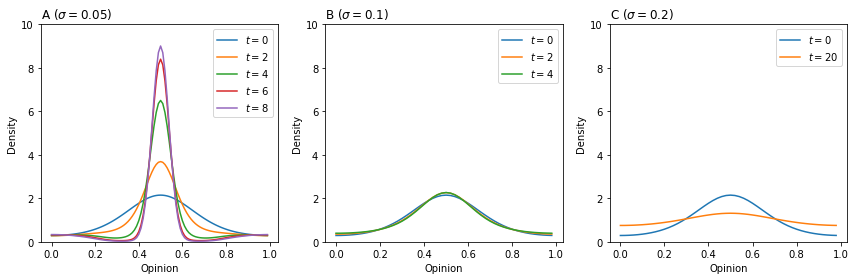

In [3]:
def plot_result(N, e_l, e_r, sigma, t_eval, ylim=[0,10]):
    xs = generate_xs(N)
    r_0 = vonmises.pdf(xs, kappa=1, scale=1/(2*np.pi), loc=0.5)
    t_end=t_eval[-1]
    y, t = dynamics(xs, r_0, e_l, e_r, sigma, t_end, t_eval=t_eval)
    for i in range(len(t)):
        plt.plot(xs, y[:,i], label="$t = $" + str(t[i]))
    plt.legend()
    plt.xlabel("Opinion")
    plt.ylabel("Density")
    plt.ylim(ylim)
    
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

plt.sca(ax[0])
plot_result(100, 0.2, 0.2, 0.05, [0,2,4,6,8])
plt.title("A ($\sigma = $" + str(0.05) + ")", loc="left")

plt.sca(ax[1])
plot_result(50, 0.2, 0.2, 0.1, [0,2,4])
plt.title("B ($\sigma = $" + str(0.1) + ")", loc="left")

plt.sca(ax[2])
plot_result(50, 0.2, 0.2, 0.11, [0,20])
plt.title("C ($\sigma = $" + str(0.2) + ")", loc="left")


plt.tight_layout()

## Figure 4.2
The second cell makes use of the result of the first cell which is stored in the `peaks_PDE.csv` file.

In [4]:
def plot_grid(i_values, j_values, matrix, i_values_label, j_values_label):
    mss, ess = np.meshgrid(j_values, i_values)
    plt.pcolormesh(ess, mss, matrix, cmap="viridis")
    plt.colorbar()
    plt.xlabel(i_values_label)
    plt.ylabel(j_values_label)
    
pts = 20
es = np.linspace(0.05, 0.45, pts)
ss = np.linspace(0.05, 0.45, pts)
peak_matrix = np.zeros([pts, pts])

N = 100
t_eval = [0,1]
xs = generate_xs(N)
r_0 = vonmises.pdf(xs, kappa=1, scale=1/(2*np.pi), loc=0.5)
t_end=t_eval[-1]


# for i in range(pts):
#     e_l = es[i]
#     e_r = e_l
#     for j in range(pts):
#         clear_output(wait=True)
#         print("progress: ", i, " out of ", pts)
#         print("progress: ", j, " out of ", pts)
#         sigma = ss[j]
#         #print(e_l, "-----", sigma)
#         y, t = dynamics(xs, r_0, e_l, e_r, sigma, t_end, t_eval=t_eval)
#         peak_matrix[i,j] = max(y[:,-1])
# 
# np.savetxt('./savedResults/peaks_PDE.csv', peak_matrix, delimiter=';')

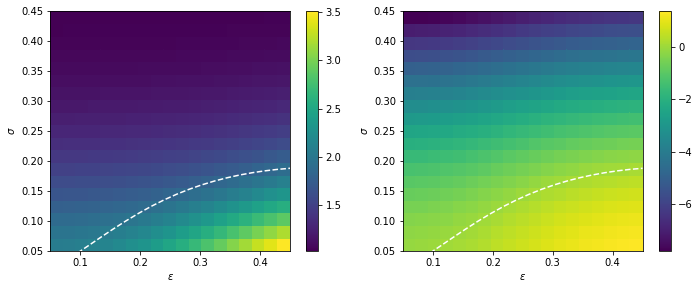

In [5]:
from scipy.special import i0
from scipy.optimize import root
from scipy.integrate import quad

def plot_grid(i_values, j_values, matrix, i_values_label, j_values_label):
    mss, ess = np.meshgrid(j_values, i_values)
    plt.pcolormesh(ess, mss, matrix, cmap="viridis")
    plt.colorbar()
    plt.xlabel(i_values_label)
    plt.ylabel(j_values_label)
    plt.axis('square')

def derivative(e, s):
    # calculates the time derivative at x=0.5 at time t=0 for given initial condition
    I_o = i0(1)
    const = -4*(np.pi**2)*np.e/I_o
    
    def rho(x):
        return np.exp(np.cos(2*np.pi*(x-0.5)))/I_o
    integral = quad(rho, 0.5-e, 0.5+e)
    
    return (integral[0] + (-2*e*rho(0.5+e)))*np.e/I_o + const*(s**2)/2

def find_sigma(e):
    # returns sigma such that the time derivative at x=0.5 at t=0 is zero for a given epsilon
    def der(s):
        return derivative(e,s)
    return root(der, x0=0.2)


fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

plt.sca(ax[0])
peak_matrix = np.genfromtxt('./savedResults/peaks_PDE.csv', delimiter=';')
plot_grid(es, ss, peak_matrix, "$\epsilon$", "$\sigma$")
zero_ss = []
for e in es:
    zero_ss.append(find_sigma(e).x[0])
plt.plot(es, zero_ss, color="white", linestyle="--")

plt.sca(ax[1])
derivatives = np.zeros([pts, pts])
for i in range(pts):
    e = es[i]
    for j in range(pts):
        s = ss[j]
        derivatives[i,j] = derivative(e,s)
plot_grid(es, ss, derivatives, "$\epsilon$", "$\sigma$")
plt.plot(es, zero_ss, color="white", linestyle="--")

plt.tight_layout()

## Figure 4.5

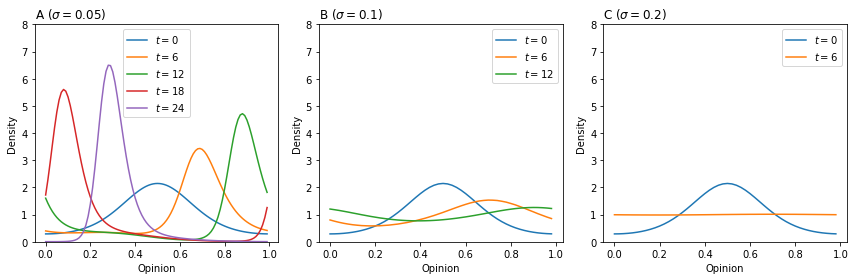

In [6]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

plt.sca(ax[0])
plot_result(100, 0.0, 0.2, 0.05, [0,6,12,18,24], ylim=[0,8])
plt.title("A ($\sigma = $" + str(0.05) + ")", loc="left")

plt.sca(ax[1])
plot_result(50, 0.0, 0.2, 0.1, [0,6,12], ylim=[0,8])
plt.title("B ($\sigma = $" + str(0.1) + ")", loc="left")

plt.sca(ax[2])
plot_result(50, 0.0, 0.2, 0.2, [0,6], ylim=[0,8])
plt.title("C ($\sigma = $" + str(0.2) + ")", loc="left")

plt.tight_layout()

## Figure 4.6

C:\Users\nikol\Anaconda3\lib\site-packages\ipykernel_launcher.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


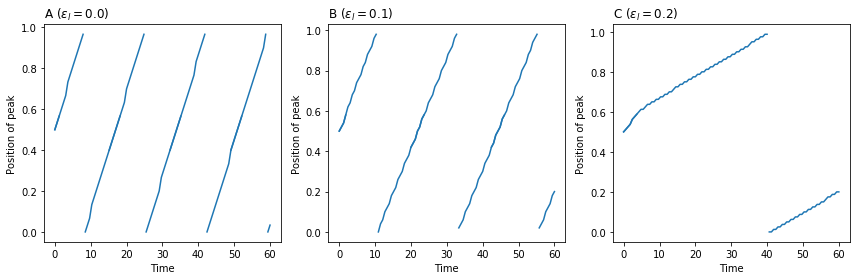

In [7]:
def plot_peakPosition(N, e_l, e_r, sigma, t_eval):
    xs = generate_xs(N)
    r_0 = vonmises.pdf(xs, kappa=1, scale=1/(2*np.pi), loc=0.5)
    t_end=t_eval[-1]
    y, t = dynamics(xs, r_0, e_l, e_r, sigma, t_end, t_eval=t_eval)
    x_peaks = np.zeros(len(t))
    for i in range(len(t)):
        x_peaks[i] = xs[np.argmax(y[:,i])]
        
    upper = x_peaks >= 0.4
    lower = x_peaks < 0.6
    h = np.ma.masked_where(~upper, x_peaks)
    g = np.ma.masked_where(~lower, x_peaks)
    plt.plot(t, g, color = "C0")
    plt.plot(t, h, color = "C0")
    plt.ylabel("Position of peak")
    plt.xlabel("Time")
    
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(12, 4)

plt.sca(ax[0])
plot_peakPosition(30, 0, 0.5, 0.1, np.linspace(0,60,100))
plt.title("A ($\epsilon_l = $" + str(0.0) + ")", loc="left")

plt.sca(ax[1])
plot_peakPosition(50, 0.1, 0.5, 0.1, np.linspace(0,60,100))
plt.title("B ($\epsilon_l = $" + str(0.1) + ")", loc="left")

plt.sca(ax[2])
plot_peakPosition(80, 0.2, 0.5, 0.1, np.linspace(0,60,100))
plt.title("C ($\epsilon_l = $" + str(0.2) + ")", loc="left")

plt.tight_layout()

## Figure 4.7
The second cell makes use of the results of the first cell are is stored in the following `.csv` files:
- `PDE_periods_00_03.csv`
- `PDE_periods_01_03.csv`
- `PDE_periods_02_03.csv`
- `PDE_periods_04_03.csv`
- `PDE_periods_00_05.csv`
- `PDE_periods_02_05.csv`
- `PDE_periods_04_05.csv`

where the first number corresponds to $\varepsilon_\ell$ and the second number corresponds to $\varepsilon_r$ (i.e. the second file corresponds to $\varepsilon_\ell = 0.1$, $\varepsilon_r = 0.3$).

In [8]:
from scipy.signal import argrelextrema 
from IPython.display import clear_output
    
def get_period(N, e_l, e_r, sigma, t_eval):
    xs = generate_xs(N)
    r_0 = vonmises.pdf(xs, kappa=1, scale=1/(2*np.pi), loc=0.5)
    t_end=t_eval[-1]
    y, t = dynamics(xs, r_0, e_l, e_r, sigma, 1, t_eval=[0,1])
    if max(y[:,0]) > max(y[:,-1]):
        return 0
    else:
        y, t = dynamics(xs, r_0, e_l, e_r, sigma, t_end, t_eval=t_eval)
        x_peeks = np.zeros(len(t))
        for i in range(len(t)):
            x_peeks[i] = xs[np.argmax(y[:,i])]

        count = 0
        for i in range(1, len(t)):
            if x_peeks[i-1] - x_peeks[i] > 0.5:
                count += 1
        return count/t_eval[-1]

def save_result(e_l, e_r, sample_pts):
    sigmas = np.linspace(0,0.3,sample_pts)
    periods = np.zeros(sample_pts)
    for i in range(sample_pts):
        clear_output(wait=True)
        print("progress: " + str(i) + " out of " + str(sample_pts))
        periods[i] = get_period(60, e_l, e_r, sigmas[i], np.linspace(0,200,50))
    elStr = str(e_l).replace('.', '')
    erStr = str(e_r).replace('.', '')
    np.savetxt('./savedResults/PDE/PDE_periods_'+ elStr + '_' + erStr + '_HUH.csv', periods, delimiter=';')

sample_pts = 40
# save_result(0.0, 0.5, sample_pts)
# save_result(0.2, 0.5, sample_pts)
# save_result(0.4, 0.5, sample_pts)
# save_result(0.0, 0.3, sample_pts)
# save_result(0.1, 0.3, sample_pts)
# save_result(0.2, 0.3, sample_pts)
# save_result(0.4, 0.3, sample_pts)

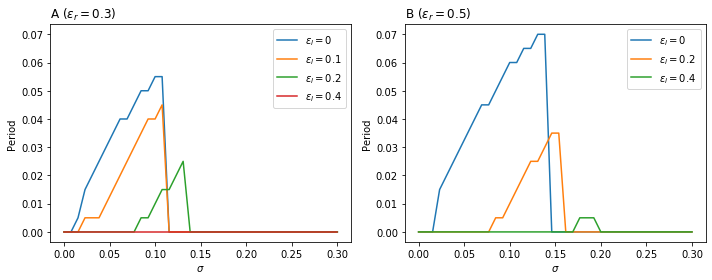

In [9]:
sigmas = np.linspace(0,0.3,sample_pts)

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

plt.sca(ax[0])
a = np.genfromtxt('./savedResults/PDE/PDE_periods_00_03.csv', delimiter=';')
plt.plot(sigmas, a, label="$\epsilon_l = 0$")
b = np.genfromtxt('./savedResults/PDE/PDE_periods_01_03.csv', delimiter=';')
plt.plot(sigmas, b, label="$\epsilon_l = 0.1$")
c = np.genfromtxt('./savedResults/PDE/PDE_periods_02_03.csv', delimiter=';')
plt.plot(sigmas, c, label="$\epsilon_l = 0.2$")
d = np.genfromtxt('./savedResults/PDE/PDE_periods_04_03.csv', delimiter=';')
plt.plot(sigmas, d, label="$\epsilon_l = 0.4$")

plt.title("A ($\epsilon_r = 0.3$)", loc="left")
plt.xlabel("$\sigma$")
plt.ylabel("Period")
plt.legend()


plt.sca(ax[1])
a = np.genfromtxt('./savedResults/PDE/PDE_periods_00_05.csv', delimiter=';')
plt.plot(sigmas, a, label="$\epsilon_l = 0$")
b = np.genfromtxt('./savedResults/PDE/PDE_periods_02_05.csv', delimiter=';')
plt.plot(sigmas, b, label="$\epsilon_l = 0.2$")
c = np.genfromtxt('./savedResults/PDE/PDE_periods_04_05.csv', delimiter=';')
plt.plot(sigmas, c, label="$\epsilon_l = 0.4$")

plt.title("B ($\epsilon_r = 0.5$)", loc="left") 
plt.xlabel("$\sigma$")
plt.ylabel("Period")
plt.legend()


y_min = min(ax[1].get_ylim()[0], ax[0].get_ylim()[0])
y_max = max(ax[1].get_ylim()[1], ax[0].get_ylim()[1])
plt.sca(ax[0])
plt.ylim([y_min, y_max])
plt.sca(ax[1])
plt.ylim([y_min, y_max])

plt.tight_layout()